# CLIP feature extractor

In [6]:
import sys
import re
import os
import torch
import torch.nn.functional as F
from torchvision.datasets import CIFAR100, MNIST
from torchvision import transforms
from tqdm import trange
from matplotlib import pyplot as plt
from collections import Counter
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
import umap.umap_ as umap
from pytorch_pretrained_vit import ViT
import json
import pickle 
import pathlib
import PIL
from tqdm import tqdm, trange
from colors import blue, red, green, cyan
from collections import Counter
from transformers import BertTokenizer
import ruamel.yaml as yaml
from scipy.optimize import linear_sum_assignment
import math

sys.path.append('ANONYMOUS_ROOTDIR/develop/open-world/CLIP')
import clip
from clip.model import CLIP

In [8]:
#Load data
TEXT_DATASET_FILE = "data/painting_descriptions.pickle"
text_dataset_path = f"{TEXT_DATASET_FILE}"
text_dataset = pickle.load(open(text_dataset_path,"rb"))
print(text_dataset.keys())

dict_keys(['painting_ids', 'painting_descriptions:'])


In [9]:
# setup device to use
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [ ]:
device = "cpu"

################################## PRETRAIN ##################################
model, preprocess = clip.load('ViT-B/16', device)
################################## PRETRAIN ##################################
model = CLIP(
        embed_dim=512,
        image_resolution=224, 
        vision_layers=12, 
        vision_width=768, 
        vision_patch_size=16,
        context_length=77, 
        vocab_size=49408, 
        transformer_width=512, 
        transformer_heads=8, 
        transformer_layers=12
    ).to(device)
model.eval()

In [11]:
from transformers import XLNetTokenizer

tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
tokenizer.tokenize("Don't you love 🤗 Transformers? We sure do.")

['▁Don',
 "'",
 't',
 '▁you',
 '▁love',
 '▁',
 '🤗',
 '▁',
 'Transform',
 'ers',
 '?',
 '▁We',
 '▁sure',
 '▁do',
 '.']

In [ ]:
painting_ids, image_features, text_features, image_inputs, text_inputs = [], [], [], [], []

image_files_names = os.listdir("data/images/")
painting_ids_dict = dict.fromkeys(text_dataset["painting_ids"], "YES")

for i in range(0, len(image_files_names)):
    painting_name = re.sub(".jpg", "", image_files_names[i])
    if painting_name in painting_ids_dict.keys():
        painting_ids.append(painting_name)
        idx_of_painting = text_dataset["painting_ids"].index(painting_name)
        
        text_input = text_dataset["painting_descriptions:"][idx_of_painting]
        text_input = (text_input[:77] + '..') if len(text_input) > 77 else text_input

        
        text_input = clip.tokenize(text_input).to(device)
        
        im = PIL.Image.open(pathlib.Path(f"data/images/{image_files_names[i]}"))
        image_input = preprocess(im).unsqueeze(0).to(device)
        with torch.no_grad():

            image_feature = model.encode_image(image_input)
            image_feature /= image_feature.norm(dim=-1, keepdim=True)
            image_feature = image_feature.cpu().numpy()[0]

            text_feature = model.encode_text(text_input)
            text_feature /= text_feature.norm(dim=-1, keepdim=True)
            text_feature = text_feature.cpu().numpy()[0]
         
        image_inputs.append(image_input.cpu().numpy()[0])
        text_inputs.append(text_input.cpu().numpy()[0])
        image_features.append(image_feature)
        text_features.append(text_feature)

        #if len(image_features) == 500: break

image_inputs = torch.tensor(image_inputs)
text_inputs = torch.tensor(text_inputs)
image_features = torch.tensor(image_features)
text_features = torch.tensor(text_features)
        


In [ ]:
#Compute image-text similarity
#((image_features @ text_features.T).argmax(dim=-1) == torch.arange(500)).float().mean()
sim =text_features.cpu().numpy() @ image_features.cpu().numpy().T

In [ ]:
sim.shape

In [ ]:
image_feature.shape

In [ ]:
sim[0]

In [ ]:
#Save similarity matrix
clip_cosine = np.save('clip_cosine-mat', sim)

## Visualize Modality gap

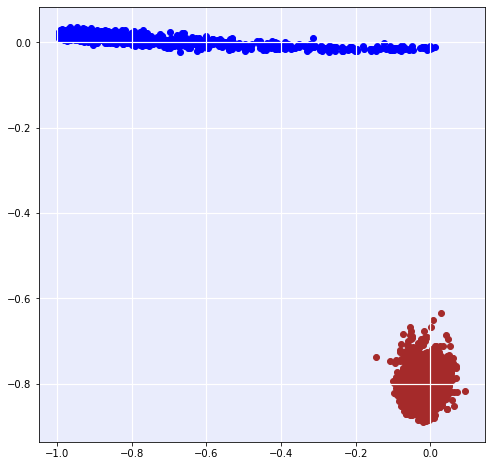

In [18]:
# Use PCA to reduce dimensionality
all_img_features, all_text_features = np.load('features_clip_random.npy')

def svd(X, n_components=2):
    # using SVD to compute eigenvectors and eigenvalues
    # M = np.mean(X, axis=0)
    # X = X - M
    U, S, Vt = np.linalg.svd(X)
    # print(S)
    return U[:, :n_components] * S[:n_components]

features_2d = svd(np.concatenate([all_img_features, all_text_features], 0))
plt.figure(figsize=(8, 8))
ax = plt.axes()


ax.set_facecolor("#e9ecfc")
ax.grid(which='major', color='white', linewidth=1.2)
ax.grid(which='minor', color='white', linewidth=0.6)
plt.scatter(features_2d[:-len(all_img_features), 0], features_2d[:-len(all_img_features), 1], c='blue')
plt.scatter(features_2d[-len(all_img_features):, 0], features_2d[-len(all_img_features):, 1], c='brown')

plt.savefig('RecSys_CLIP.pdf')  
# connect the dots
#for i in range(len(all_img_features)):
    #plt.plot([features_2d[i, 0], features_2d[len(all_img_features)+i, 0]], [features_2d[i, 1], features_2d[len(all_img_features)+i, 1]], c='yellow', alpha=0.1)

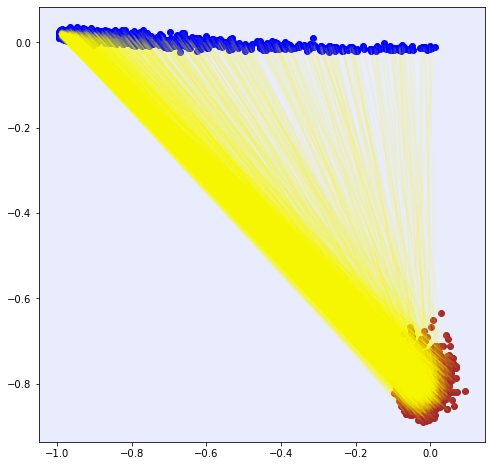

In [22]:
# Use PCA to reduce dimensionality
all_img_features, all_text_features = np.load('/Users/bereket.yilma/Documents/Projects/CLIP/features_clip_random.npy')

def svd(X, n_components=2):
    # using SVD to compute eigenvectors and eigenvalues
    # M = np.mean(X, axis=0)
    # X = X - M
    U, S, Vt = np.linalg.svd(X)
    # print(S)
    return U[:, :n_components] * S[:n_components]

features_2d = svd(np.concatenate([all_img_features, all_text_features], 0))
plt.figure(figsize=(8, 8))
ax = plt.axes()


ax.set_facecolor("#e9ecfc")
#ax.grid(which='major', color='white', linewidth=1.2)
#ax.grid(which='minor', color='white', linewidth=0.6)
plt.scatter(features_2d[:-len(all_img_features), 0], features_2d[:-len(all_img_features), 1], c='blue')
plt.scatter(features_2d[-len(all_img_features):, 0], features_2d[-len(all_img_features):, 1], c='brown')

plt.savefig('RecSys_CLIP.pdf')  
# connect the dots
for i in range(len(all_img_features)):
    plt.plot([features_2d[i, 0], features_2d[len(all_img_features)+i, 0]], [features_2d[i, 1], features_2d[len(all_img_features)+i, 1]], c='yellow', alpha=0.1)